Automatically Scoring Student Responses

Avi Dixit and Elizabeth McBride

<b>Introduction </b> Notebook to upload the pre and post test data into pandas dataframes and apply classification algorithms to it.


In [60]:
#imports - Consolidated imports for all functions used (or will eventually be used) by the notebook

import nltk
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint
%matplotlib inline

import re
import math
import string
from collections import Counter
from __future__ import division
from time import time
import logging

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.multiclass import OneVsOneClassifier
from sklearn import svm
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.metrics import cohen_kappa_score
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

from nltk import word_tokenize
from nltk.corpus import wordnet as wn
from nltk.stem import WordNetLemmatizer 
from nltk.stem import SnowballStemmer

Pretty plot confusion matrix

In [61]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

class_names = [1, 2, 3, 4, 5]

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [2]:
#read_file is a helper function to get the '|' delimited CSV into a data frame
def read_file(filename):
    #get the file
    df = pd.read_csv(filename, error_bad_lines=False, encoding = 'mbcs')
    
    #Force KIScore to int, otherwise reverts to float. Same for Answer. Forcing NaN to unicode
    df['KIScore'] = df['KIScore'].astype(int)
    df['Answer'] = df['Answer'].astype(str)
    # Filters if needed later on
    #filtered_data = df["Answer"].notnull()
    #filtered_data = df[df["KIScore"] != 1 & df['Answer'].notnull() & df["KIScore"].notnull()]
    #df_narrative = df[filtered_data]
    return df

#reads in the training data into a panda - Steve 
#(code based on ANLP Notebook Intro to Pandas by Marti Hearst and Andrea Gagliano)
def read_training_data(filename):
    df_narrative = read_file(filename)
    #print the report on category breakdown, might need these counts later
    #print("Creating training data... category breakdown:")
    #sorted_product_counts = df_narrative.Category.value_counts(ascending=True)
    #print(sorted_product_counts)
    #sorted_product_counts.plot(kind='barh', figsize=(8,6), title="Categories");
    return df_narrative

Seperate the data into training and dev data.

In [3]:
#breaks the panda into a training set and a dev set - Currently only genereates dev and test data
#Modify the function later to keep some data as test data as well

def get_train_and_dev_sets(full_data, percent_dev):
    #randomize the indices
    random_index = np.random.permutation(full_data.index)
    full_data_shuffled = full_data.ix[random_index, ['WISEID', 'Answer', 'KIScore']]
    full_data_shuffled.reset_index(drop=True, inplace=True)
    
    #break down the counts for the shuffled data
    rows, columns = full_data_shuffled.shape
    train_size = round(rows*(1 - percent_dev))
    dev_size   = round(rows*percent_dev)
    
    #separate the training data from the development data
    train_data = full_data_shuffled.loc[:train_size]
    dev_data = full_data_shuffled.loc[train_size:dev_size+train_size].reset_index(drop=True)

    return train_data, dev_data 

In [4]:
#reads in the test file into a panda
def read_test_data(filename):
    #get the file
    df = read_file(filename)
    return df

In [5]:
#the code that calls the above functions - puts the data into a data frame
df = read_training_data("Car1.csv")
train_set, dev_set = get_train_and_dev_sets(df,.2)

Spell checker created by Peter Norvig

In [6]:
TEXT = open('big.txt').read()

def tokens(text):
    "List all the word tokens (consecutive letters) in a text. Normalize to lowercase."
    #print(re.findall('[a-z]+', text.lower()))
    return re.findall('[a-z]+', text.lower())

def tokens_target(text):
    "List all the word tokens (consecutive letters) in a text. Normalize to lowercase."
    words = re.findall('[a-z]+', text.lower())
    tagged_POS_sents = nltk.pos_tag(words) # tags sents
    #normed_tagged_words = [wnl.lemmatize(word[0].lower()) for sent in tagged_POS_sents
                           #for word in sent 
                           #if word[0].lower() not in nltk.corpus.stopwords.words('english')
                           #and word[0] not in punctuation # remove punctuation
                           #and not re.search(r'''^[\.,;"'?!():\-_`]+$''', word[0])
                           #and word[1].startswith('N')]  # include only nouns
    #print(tagged_POS_sents)
    if (len(tagged_POS_sents) > 1):
        normed_tagged_words = [word[0].lower() for word in tagged_POS_sents
                              if (word[1].startswith('N') or word[1].startswith('J') or word[1].startswith('V'))]
        return normed_tagged_words
    else:
        return words

WORDS = tokens(TEXT)

COUNTS = Counter(WORDS)

In [7]:
def correct(word):
    "Find the best spelling correction for this word."
    # Prefer edit distance 0, then 1, then 2; otherwise default to word itself.
    candidates = (known(edits0(word)) or 
                  known(edits1(word)) or 
                  known(edits2(word)) or 
                  [word])
    return max(candidates, key=COUNTS.get)

# Show what happens in the case of ties
def correct_under_hood (word):
    candidates = (known(edits0(word)) or 
                  known(edits1(word)) or 
                  known(edits2(word)) or 
                  [word])
    return candidates

In [8]:
def known(words):
    "Return the subset of words that are actually in the dictionary."
    return {w for w in words if w in COUNTS}

def edits0(word): 
    "Return all strings that are zero edits away from word (i.e., just word itself)."
    return {word}

def edits2(word):
    "Return all strings that are two edits away from this word."
    return {e2 for e1 in edits1(word) for e2 in edits1(e1)}

In [9]:
def edits1(word):
    "Return all strings that are one edit away from this word."
    pairs      = splits(word)
    deletes    = [a+b[1:]           for (a, b) in pairs if b]
    transposes = [a+b[1]+b[0]+b[2:] for (a, b) in pairs if len(b) > 1]
    replaces   = [a+c+b[1:]         for (a, b) in pairs for c in alphabet if b]
    inserts    = [a+c+b             for (a, b) in pairs for c in alphabet]
    return set(deletes + transposes + replaces + inserts)

def splits(word):
    "Return a list of all possible (first, rest) pairs that comprise word."
    return [(word[:i], word[i:]) 
            for i in range(len(word)+1)]

alphabet = 'abcdefghijklmnopqrstuvwxyz'

In [10]:
spell_checker = lambda x : ' '.join(i for i in list(map(correct, tokens(x))))

In [11]:
train_set['Answer'] = train_set['Answer'].apply(spell_checker)

In [12]:
train_set.head()

,WISEID,Answer,KIScore
0,136468.0,if its really hot outside the temperature in t...,2
1,154163.0,it a very,2
2,118576.0,i think this because the the car heat up,2
3,136500.0,i chose this answer because the sun is beating...,2
4,154226.0,the car is in the sun so it is going to be warmer,2


In [13]:
dev_set['Answer'] = dev_set['Answer'].apply(spell_checker)

In [14]:
dev_set.head()

,WISEID,Answer,KIScore
0,139516.0,it is going to be warmer the air outside the c...,3
1,150127.0,i chose warmer than the outside air because th...,3
2,154322.0,i chose warmer than the outside air because if...,2
3,151208.0,it is in the sun so it is warmer,2
4,150132.0,since the car has been sitting out in the sun ...,3


<b> Strategies that need to be attempted </b>
1. Feature Selection attempted:
    1. counts of Unigrams only 
    2. ... Unigrams and Bigrams
    3. ... Unigrams, Bigrams, and Trigrams
    4. ... Bigrams and Trigrams
    5. ... 4- and 5-gram combinations
    6. The use of TF-IDF, with IDF and without
    7. Word tokens that included punctuation and numbers
    8. Word tokens with letters only, filtering punctuation or splitting on punctuation
    9. Lemmatizing using Word Net
    10. Stemming using Snowball
    11. With and without stopwords
    12. With and without lowercasing
    13. Chunking out all words that are not nouns.
    14. Stemming user Porter and Lancaster stemmers.
    15. Checking most common hypernyms of nouns in the review to categorise reviews better.
    16. Using feature unions in pipelines to select specific features.
2. Classifiers used:
    1. Linear: Naive Bayes, Linear Regression, Stochastic Gradiant Descent
    2. SVC and Linear SVC (One vs One, One vs Many)
    3. K - Nearest Neighbor
    4. MLP
    5. Voting classifiers with hard and soft voting.

In [15]:
def transform_dfs_to_arrays(train_set, dev_set):
    vec = CountVectorizer(ngram_range=(1, 4), token_pattern=r'\b\w+\b', stop_words="english", max_features=5000)
    arr_train_feature_sparse = vec.fit_transform(train_set["Answer"].values.astype(str))
    arr_train_feature = arr_train_feature_sparse.toarray()
    
    arr_dev_feature_sparse = vec.transform(dev_set["Answer"].values.astype(str))
    arr_dev_feature = arr_dev_feature_sparse.toarray()
        
    return arr_train_feature, arr_dev_feature


Lets start with a simple Naive Bayes classifier for Multinomial models

In [16]:
def train_NB_model(train_set, arr_train):
    nb = MultinomialNB()
    nb_model = nb.fit(arr_train, 
                      train_set.KIScore)
    return nb_model

In [17]:
arr_train, arr_dev = transform_dfs_to_arrays(train_set, dev_set)
nb_model = train_NB_model(train_set, arr_train)
nb_predictions = nb_model.predict(arr_dev)

In [18]:
accuracy_score(dev_set.KIScore, nb_predictions)

0.79217603911980439

Lets try K-nearest neighbor

In [19]:
def train_KNearest_model(train_set, arr_train):
    #Should add and experiement with more parameters and algorithms for nearest neighbor
    nb = KNeighborsClassifier(n_neighbors=5)
    nb_model = nb.fit(arr_train, 
                      train_set.KIScore)
    return nb_model

In [20]:
neigh_model = train_KNearest_model(train_set, arr_train)
ne_predictions = neigh_model.predict(arr_dev)
accuracy_score(dev_set.KIScore, ne_predictions)

0.65281173594132025

Not bad for a start, lets move onto Logistical Regression

In [21]:
def train_LR_model(train_set, arr_train):
    logreg = LogisticRegression()
    lr_model = logreg.fit(arr_train, train_set.KIScore)
    return lr_model

In [22]:
lr_model = train_LR_model(train_set, arr_train)
lr_predictions = lr_model.predict(arr_dev)

In [23]:
accuracy_score(dev_set.KIScore, lr_predictions)

0.80195599022004893

Already nearing 80s!!!! But remember, need to measure Cohen's Kappa, not percetage correct. Also start plotting confusion matrix and extract errors once the classifiers are worked out.

Lets start with the pipeline for the best features and get to feature detections using SVM. Also need to perform all the combinations mentioned before (Including preprocessing). 

In [24]:
class LemmaTokenizer(object):
    def __init__(self):
        self.wnl = WordNetLemmatizer()
        #self.snow = SnowballStemmer('english')
    
    #this code will filter punctuation from a word and rejoin it together ("they're" becomes "theyre")
    def __preprocess(self, doc):
       filter_punc = lambda t: ''.join([x.lower() for x in t if x.isalpha()])
       words = [x for x in map(filter_punc, doc.split()) if x]
       review = ""
       for w in words:
           review = review+" "+w
       return review
    
    #Multiple attempts to select lemmas and stems from a word token (using NLTK)
    def __call__(self, doc):
        #return [self.wnl.lemmatize(t.lower()) for t in word_tokenize(doc)]
        return [self.wnl.lemmatize(t) for t in word_tokenize(self.__preprocess(doc))]
        #return ["".join([str(s.name()) for s in wn.synset(t).hypernyms()]) for t in word_tokenize(self.__preprocess(doc))]
        #return [self.snow.stem(t) for t in word_tokenize(self.__preprocess(doc))]

In [25]:
from collections import Counter
from nltk import FreqDist
from nltk import word_tokenize
from nltk.corpus import wordnet as wn
from nltk.stem import WordNetLemmatizer 
from nltk.stem import SnowballStemmer
from nltk.stem import PorterStemmer
from string import punctuation
    
def stuff(doc):
    #flatten = [w for sent in doc for w in sent]
    flatten = [w for w in word_tokenize(doc)]
    unigram_counts = Counter(flatten)
    uni_dist = FreqDist(unigram_counts)
    uni = [a for (a, b) in uni_dist.most_common(25)]
    
    sent_tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')
    raw_sents = sent_tokenizer.tokenize(doc) # Split text into sentences
    words = [nltk.word_tokenize(word) for word in raw_sents]
    wnl = WordNetLemmatizer() # to get word stems
    tagged_POS_sents = [nltk.pos_tag(word) for word in words ] # tags sents
    #print(tagged_POS_sents)
    #normed_tagged_words = [wnl.lemmatize(word[0].lower()) for sent in tagged_POS_sents
                           #for word in sent 
                           #if word[0].lower() not in nltk.corpus.stopwords.words('english')
                           #and word[0] not in punctuation # remove punctuation
                           #and not re.search(r'''^[\.,;"'?!():\-_`]+$''', word[0])
                           #and word[1].startswith('N')]  # include only nouns
    normed_tagged_words = [word[0].lower() for sent in tagged_POS_sents
                          for word in sent
                          if (word[1].startswith('N') or word[1].startswith('J'))]
    #normed_tagged_words = list(set(normed_tagged_words))
    return normed_tagged_words

#from http://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html
class LemmaTokenizer1(object):
    def __init__(self):
        self.wnl = PorterStemmer()
    def __call__(self, doc):
        return [t for t in stuff(doc)]

In [40]:
# Pipeline attempts - Best features will be decided using Grid Search. Lets just setup a baseline for now.
#from http://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html
#Note: add probability True to SVC classifier to be able to use predict probability function, which
# is crucial for the the ensemble methods tried later

text_clf = Pipeline([('vect', CountVectorizer(ngram_range=(1, 2), tokenizer=LemmaTokenizer(),  
                                              max_df=0.25, max_features= 15000, token_pattern=r'\b\w+\b', 
                                              stop_words="english")),
                      ('dim', LDA(n_components=1)),
                      ('tfidf', TfidfTransformer(use_idf = True, norm='l2')),
                      ('log', LogisticRegression(class_weight = None )),
                      ('clf', SVC(C = 1000000.0, gamma='auto', kernel='linear', probability = True))])
                      #('clf', LinearSVC(C=1.0, random_state=69, penalty='l2', dual=True, tol=1e-5, class_weight = None))])
                      #('clf', OneVsOneClassifier(LinearSVC(random_state=0)))])                    
                      #('clf', SGDClassifier(loss='hinge', alpha=1e-5, penalty='elasticnet', n_iter=50, random_state=69))])

In [41]:
pipeline_predictor = text_clf.fit(train_set["Answer"], 
                                  train_set.KIScore)

predicted = pipeline_predictor.predict(dev_set["Answer"])
accuracy_score(dev_set.KIScore, predicted)

ValueError: could not convert string to float: 'it is going to be warmer the air outside the car because the air inside the car is warm and it gets wrapped inside the car'

In [28]:
pd.crosstab(dev_set.KIScore, predicted, 
           rownames=['True'], colnames=['Predicted'], 
            margins=True)

Predicted,1,2,3,4,5,All
True,,,,,,
1,9,1,0,0,0,10
2,15,255,20,1,0,291
3,7,37,32,2,0,78
4,0,9,6,9,0,24
5,0,0,1,3,2,6
All,31,302,59,15,2,409


Lets try some ensemble classifiers (Both averaging and boosting)

In [29]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel

forest_clf = RandomForestClassifier(n_estimators=100)

f_clf = Pipeline([
  ('feature_selection', SelectFromModel(LinearSVC(C = 100, penalty="l1", dual = False))),
  ('classification', forest_clf)
])

forest_predictor = f_clf.fit(arr_train, train_set.KIScore)
f_predicted = forest_predictor.predict(arr_dev)
accuracy_score(dev_set.KIScore, f_predicted)

0.78484107579462103

In [30]:
from sklearn.model_selection import cross_val_score
from sklearn.datasets import load_iris
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(n_estimators=100)

ada_predictor = ada_clf.fit(arr_train, train_set.KIScore)
a_predicted = ada_predictor.predict(arr_dev)
accuracy_score(dev_set.KIScore, a_predicted)

0.75550122249388751

In [31]:
from sklearn.datasets import make_hastie_10_2
from sklearn.ensemble import GradientBoostingClassifier

grad_clf = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,
                                      max_depth=1, random_state=0).fit(arr_train, train_set.KIScore)
grad_predictor = grad_clf.fit(arr_train, train_set.KIScore)
grad_predicted = grad_predictor.predict(arr_dev)
accuracy_score(dev_set.KIScore, grad_predicted)

0.79951100244498774

And moving on to voting classifier with hard voting

In [32]:
from sklearn import datasets
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.neural_network import MLPClassifier

clf1 = LogisticRegression(random_state=1)
clf2 = RandomForestClassifier(random_state=1, n_estimators = 100)
clf3 = GaussianNB()
clf4 = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,
                                      max_depth=1, random_state=0)
clf5 = SGDClassifier(loss='hinge', alpha=1e-5, penalty='elasticnet', n_iter=50, random_state=69)
clf6 = SVC(C = 1000000.0, gamma='auto', kernel='rbf', probability = True)
clf8 = MLPClassifier(solver='lbfgs', alpha=1e-5,
                    hidden_layer_sizes=(5, 2), random_state=1)

eclf = VotingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('gnb', clf3), 
                                    ('clf6', clf6),
                                   ('clf4', clf4), ('clf5', clf5), ('clf8', clf8)], voting='hard')

eclf_predictor = eclf.fit(arr_train, train_set.KIScore)
v_predicted = eclf_predictor.predict(arr_dev)
accuracy_score(dev_set.KIScore, v_predicted)

0.79217603911980439

In [ ]:
for clf, label in zip([clf1, clf2, clf3, clf4, clf5, clf6, clf8, eclf], ['Logistic Regression', 'Random Forest', 
                                                                  'naive Bayes', 'Gradient Boosting', 'SGD', 'SVC', 
                                                                  'MLP', 'Ensemble']):
    scores = cross_val_score(clf, arr_train, train_set.KIScore, cv=5, scoring='accuracy')
    print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))

Voting classifier with soft voting

Note: The MLP classifier improved accuracy for both hard and sofr voting

But, I need to do a ton of cross validation for the correct parameters and classifiers for each question type. Not to mention, need to get the grid search working well for these things.

TODO: Find optimal weights for the classifiers

TODO: Need to do feature engineering to get better parameters. This isnt working too well.

In [ ]:
clf1 = LogisticRegression(random_state=1)
clf2 = RandomForestClassifier(random_state=1, n_estimators = 100)
clf3 = GaussianNB()
clf4 = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,
                                      max_depth=1, random_state=0)
clf6 = SVC(C = 1000000.0, gamma='auto', kernel='rbf', probability = True)
clf8 = MLPClassifier(solver='lbfgs', alpha=1e-5,
                    hidden_layer_sizes=(5, 2), random_state=1)

eclf_s = VotingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('gnb', clf3), 
                                    ('clf6', clf6),
                                   ('clf4', clf4), ('clf8', clf8)], voting='soft')

eclf_s_predictor = eclf_s.fit(arr_train, train_set.KIScore)
s_predicted = eclf_s_predictor.predict(arr_dev)
accuracy_score(dev_set.KIScore, s_predicted)

In [ ]:
for clf, label in zip([clf1, clf2, clf3, clf4, clf6, clf8, eclf], ['Logistic Regression', 'Random Forest', 
                                                                  'naive Bayes', 'Gradient Boosting', 'SVC', 
                                                                  'MLP', 'Ensemble']):
    scores = cross_val_score(clf, arr_train, train_set.KIScore, cv=5, scoring='accuracy')
    print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))

Lets use a brute force method to find the optimal weights

In [ ]:
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import cross_val_score

df = pd.DataFrame(columns=('w1', 'w2', 'w4', 'w5', 'w6', 'mean', 'std'))

clf1 = LogisticRegression(random_state=1)
clf2 = RandomForestClassifier(random_state=1, n_estimators = 100)
clf3 = GaussianNB()
clf4 = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,
                                      max_depth=1, random_state=0)
clf6 = SVC(C = 1000000.0, gamma='auto', kernel='rbf', probability = True)
clf8 = MLPClassifier(solver='lbfgs', alpha=1e-5,
                    hidden_layer_sizes=(5, 2), random_state=1)

t0 = time()
i = 0
for w1 in range(1,3):
    for w2 in range(1,3):
        for w4 in range(1,3):
            for w5 in range(1,3):
                for w6 in range(1,3):
                        if len(set((w1,w2,w4,w5,w6))) == 1: # skip if all weights are equal
                            continue

                        eclf = VotingClassifier(estimators=[('lr', clf1), ('rf', clf2), 
                                    ('clf6', clf6),
                                   ('clf4', clf4), ('clf8', clf8)], 
                                                  weights=[w1, w2, w4, w5, w6], voting = 'soft')
                        scores = cross_val_score(eclf, 
                                                 arr_train,
                                                 train_set.KIScore,
                                                 cv=3,
                                                 scoring='accuracy',
                                                 n_jobs= -1)

                        df.loc[i] = [w1, w2, w4, w5, w6, scores.mean(), scores.std()]
                        i += 1
                        
print("done in %0.3fs" % (time() - t0))
df.sort(columns=['mean', 'std'], ascending=False)

In [ ]:
cohen_kappa_score(dev_set.KIScore, lr_predictions)

In [33]:
clf1 = LogisticRegression(random_state=1)
clf2 = RandomForestClassifier(random_state=1, n_estimators = 100)
clf3 = GaussianNB()
clf4 = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,
                                      max_depth=1, random_state=0)
clf6 = SVC(C = 1000000.0, gamma='auto', kernel='rbf', probability = True)
clf8 = MLPClassifier(solver='lbfgs', alpha=1e-5,
                    hidden_layer_sizes=(5, 2), random_state=1)

eclf_w = VotingClassifier(estimators=[('lr', clf1), ('rf', clf2), 
                                    ('clf6', clf6),
                                   ('clf4', clf4), ('clf8', clf8)], 
                                                  weights=[1, 1, 2, 2, 2], voting = 'soft')

#eclf_w_predictor = eclf_w.fit(arr_train, train_set.KIScore)
#w_predicted = eclf_w_predictor.predict(arr_dev)
#accuracy_score(dev_set.KIScore, w_predicted)

Woops! Not very good

Lets see which categories we are getting wrong (Don't be 2!!!!)

In [34]:
pd.crosstab(dev_set.KIScore, w_predicted, 
           rownames=['True'], colnames=['Predicted'], 
            margins=True)

NameError: name 'w_predicted' is not defined

Hm, it looks like we should try and get more data. Might not be possible without mixing up student responses.

To squeeze voting classifiers into the grid, I'm restricted to using only classifiers that provide a predict_pobability function. Might be worth trying later on.

In [ ]:
pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', SVC())
])


# uncommenting more parameters will give better exploring power but will
# increase processing time in a combinatorial way
parameters = {
    'vect__max_df': (0.5, 0.75, 1.0),
    'vect__max_features': (None, 5000, 10000, 20000),
    'vect__ngram_range': ((1, 1), (1, 2)),  # unigrams or bigrams
    'tfidf__use_idf': (True, False),
    'tfidf__norm': ('l1', 'l2'),
    #'clf__alpha': (0.00001, 0.000001),
    #'clf__penalty': ('l1', 'l2'),
    #'clf_kernel': ('rbf', 'linear'),
    'clf__C': (1000, 10000)
    #'clf__n_iter': (10, 50, 80),
}

grid_search = GridSearchCV( pipeline, parameters, n_jobs=-1, verbose=1, cv = 9)

print("Performing grid search...")
print("pipeline:", [name for name, _ in pipeline.steps])
print("parameters:")
pprint(parameters)
t0 = time()
grid_search.fit(train_set["Answer"], train_set.KIScore)
print("done in %0.3fs" % (time() - t0))
print()

print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

In [ ]:
predicted_grid = grid_search.predict(dev_set["Answer"])
accuracy_score(dev_set.KIScore, predicted_grid)

In [ ]:
cohen_kappa_score(dev_set.KIScore, predicted_grid)

Ok, now that we have exhausted all classifiers without really messing around with feature engineering or feature selection, lets add custom features to the pipeline using FeatureUnion (Also, dont forget to experiment with K best and PCA)

In [69]:
#Starting with a feature on the length of the answer
#Every class created for the custom feature needs to have a method to transform and fit the data

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction import DictVectorizer
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import PCA
from nltk.stem import PorterStemmer
ps = PorterStemmer()

#Filter for question 3 to remove the David's claim condition at start
filter_answer = lambda x : ' '.join(i for i in x.split() if not (i.startswith('david') or
                                                                  i.startswith('claim')))

#train_set['Answer'] = train_set['Answer'].apply(filter_answer)
#dev_set['Answer'] = dev_set['Answer'].apply(filter_answer)

class TextStats(BaseEstimator, TransformerMixin):
    """Extract features from each document for DictVectorizer"""

    def fit(self, x, y=None):
        return self

    def transform(self, posts):
        return [{'length': len(text)}
                for text in posts.tolist()]

class Keywords_Radiation(BaseEstimator, TransformerMixin):
    """Extract features from each document for DictVectorizer"""

    def fit(self, x, y=None):
        return self

    def transform(self, posts):
        return [{'Radiation': 'radiat' in [ps.stem(i) for i in text.split()]}
                for text in posts.tolist()]
    
class Trap_Radiation(BaseEstimator, TransformerMixin):
    """Extract features from each document for DictVectorizer"""

    def fit(self, x, y=None):
        return self

    def transform(self, posts):
        return [{'Radiation': 'trap' in [ps.stem(i) for i in text.split()]
                               or 'keep' in [ps.stem(i) for i in text.split()]}
                for text in posts.tolist()]
    
#Required to convert a sparse matrix to a dense matrix. Vectorizers give out a sparse matrix but some 
#classifiers need a dense matrix to perform classification
class DenseTransformer(TransformerMixin):

    def transform(self, X, y=None, **fit_params):
        return X.todense()

    def fit_transform(self, X, y=None, **fit_params):
        self.fit(X, y, **fit_params)
        return self.transform(X)

    def fit(self, X, y=None, **fit_params):
        return self
    
from sklearn.pipeline import Pipeline, FeatureUnion

pipeline = Pipeline([
    ('features', FeatureUnion(
        transformer_list=[
        ('body_stats', Pipeline([
                    ('stats', TextStats()),  # returns a list of dicts
                    ('vect', DictVectorizer())  # list of dicts -> feature matrix
        ])),
        ('key_words_radiate', Pipeline([ # Give low weight
                    ('Radiation', Keywords_Radiation()),  # returns a list of dicts
                    ('vect', DictVectorizer())  # list of dicts -> feature matrix
        ])),
        ('key_words_trap', Pipeline([ # Give low weight
                    ('Radiation', Trap_Radiation()),  # returns a list of dicts
                    ('vect', DictVectorizer())  # list of dicts -> feature matrix
        ])),
        ('bag_of', Pipeline([
                    ('vect', CountVectorizer(ngram_range=(1, 3), tokenizer=LemmaTokenizer(),  
                                              max_df=0.25, max_features= 15000, token_pattern=r'\b\w+\b', 
                                              stop_words="english"))
                    #('tfidf_transformer', TfidfTransformer(use_idf = True, norm='l2'))
        ]))
    ],
    # weight components in FeatureUnion
        transformer_weights={
            'body_stats': 1,
            'key_words_radiate': 0.5,
            'key_words_trap': 1.0,
            'bag_of': 0.5        
        },
    )),
    ('to_dense', DenseTransformer()),    
    #('dim', LinearDiscriminantAnalysis(n_components=2)),
    #('clf', SVC(kernel='linear'))  # classifier
    ('clf', eclf_w)  # classifier
])


p_predictor = pipeline.fit(train_set['Answer'], 
                                  train_set.KIScore)

predicted = p_predictor.predict(dev_set['Answer'].values)
accuracy_score(dev_set.KIScore, predicted)

0.78728606356968212

Plotting Confusion Matrix

Confusion matrix, without normalization
[[  8   2   0   0   0]
 [  0 286   5   0   0]
 [  0  52  24   2   0]
 [  0   9  12   3   0]
 [  0   2   2   1   1]]


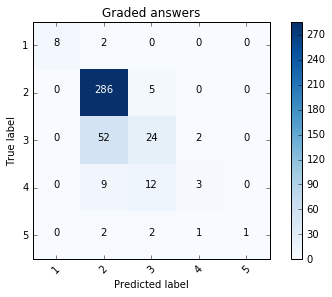

In [70]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(dev_set.KIScore, predicted)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Graded answers')